# This notebook implements the routine for flight-path calibration

        What it should be done:
        - read the theoretical spectrum
        - read the calibration sample
        - be able to convert from TOF to lambda and back
        - the peak positions are detected and single edge fitting is applied
        - calculate L, T0 or deltaL, which are the results of the calibration 
        
        time to lambda convertion:
            lambda = h/mL (t-t0)
            where:lambda = wavelength [A] (A=0.1nm = 1e-10m)
                    h = Planck's constant: 6.62607004 × 10-34 m^2 kg / s
                    m = Neutron mass [kg]: 1.674 927 471 x 10-27 kg 
                    L = total flight path [m]
                    t = time of flight [s]
        
       Convertion between time of flight and neutron wavelenght can be done after flight-path calibration: the value of the distance between the source and the transmission detector L0  and the time delay of the source trigger DT0, is obtained by linear regression to the function  lambda = h/mL (t-t0), or t= lambda(mL/h)+t0, with h= Planck constant
        
        txt files used as inputs are extracted from nxsplotter
        

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
import os, fnmatch
from os import listdir

import scipy.signal
print(scipy.__version__)
from scipy.signal import find_peaks

from ipywidgets import widgets
import IPython.display as Disp
import cv2

import AdvancedBraggEdgeFitting
from TOF_routines import find_first, find_last, find_nearest
from TOF_routines import tof2l, l2tof

import ipywe.fileselector
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Give as input the filename the theoretical spectrum (y-axis) and lambda (x-axis)
### here they are txt files extracted from nxsplotter

In [6]:
# Select theoretical spectrum file (txt)
# alternative:
# file_s_the = input('Select theoretical spectrum file (txt): ')
# ex: /home/carminati_c/git/ToFImaging/scripts/data/alpha.txt
fsel_file_spectrum= ipywe.fileselector.FileSelectorPanel(instruction='Select txt file for the reference spectrum', start_dir='.', type='file')
fsel_file_spectrum.show()

In [7]:
file_s_the = fsel_file_spectrum.selected
# ex: data/alpha.txt
print(file_s_the)

/home/carminati_c/git/ToFImaging/scripts/data/alpha.txt


In [8]:
# Select lambda txt file for the reference spectrum 
# alternative:
# file_l_th  =input('Select corresponding lambda (txt): ')
# ex: /home/carminati_c/git/ToFImaging/scripts/data/lambda.txt
fsel_file_lambda= ipywe.fileselector.FileSelectorPanel(instruction='Select txt file for the reference lambda', start_dir='.', type='file')
fsel_file_lambda.show()

In [9]:
# Select corresponding lambda
file_l_th  = fsel_file_lambda.selected
print(file_l_th)
# ex: data/lambda.txt

/home/carminati_c/git/ToFImaging/scripts/data/lambda.txt


In [10]:
mylambda = np.genfromtxt(file_l_th, usecols=0)
myspectrum = np.genfromtxt(file_s_the, usecols=0)

In [12]:
# Select list of corresponding hkls
# alternative: file_hkl = input()
# ex. data/alphaFe_hkl

fsel_file_hkl = ipywe.fileselector.FileSelectorPanel(instruction='Select txt file for the hkl list', start_dir='.', type='file')
fsel_file_hkl.show()

In [13]:
file_hkl = fsel_file_hkl.selected
dhkl_alphaFe = np.genfromtxt(file_hkl, usecols=4)
h_alphaFe= np.genfromtxt(file_hkl, usecols=0)
k_alphaFe= np.genfromtxt(file_hkl, usecols=1)
l_alphaFe= np.genfromtxt(file_hkl, usecols=2)


---- Peak positions given by the lattice parameters ----
[4.054 2.866 2.34  2.026 1.812 1.654 1.532 1.434 1.352 1.352 1.282 1.222
 1.17  1.124 1.124 1.046 1.014 0.984 0.984 0.956 0.956 0.93  0.93  0.906
 0.884 0.864 0.846 0.828 0.81  0.81  0.81  0.794 0.78  0.78  0.78  0.766
 0.752 0.728 0.728 0.716 0.706 0.706 0.706 0.696 0.696 0.686 0.676 0.676
 0.666 0.666 0.666 0.658 0.65  0.64  0.632 0.626 0.618 0.618 0.612 0.604
 0.604 0.592 0.586 0.58  0.58  0.574 0.568 0.562 0.552 0.546 0.536 0.536
 0.536 0.532 0.518 0.506 0.498 0.496 0.492 0.488 0.478 0.45  0.448 0.414]


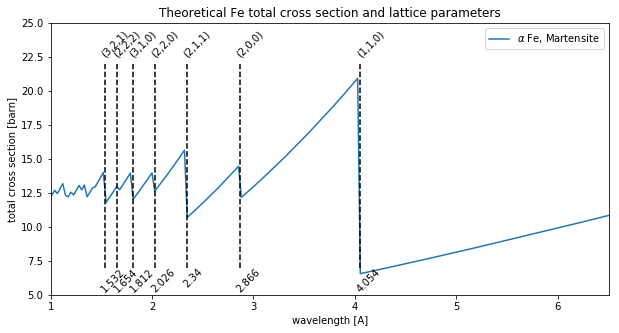

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(mylambda, myspectrum, label=r'$\alpha$ Fe, Martensite')

for i in range(0,7):
    plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([7,22]), '--k')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i]-0.05,24, mytext, rotation=45, color='k')
    plt.text(2*dhkl_alphaFe[i]-0.05,6.5, str(2*dhkl_alphaFe[i]), rotation=45, color='k')

plt.legend(loc='upper right')
plt.xlim(1,6.5)
plt.ylim(5,25)
plt.ylabel('total cross section [barn]')
plt.xlabel('wavelength [A]')
plt.title('Theoretical Fe total cross section and lattice parameters')

print('---- Peak positions given by the lattice parameters ----')
print(dhkl_alphaFe*2)

## Read the measured spectra file for the TOF calibration sample scan
### spectra txt file

In [17]:
# Select spectra txt file
# alternative :
# spectra_txt_file = input("Select spectra file (txt): ")
# ex: /media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt

fsel_spectra = ipywe.fileselector.FileSelectorPanel(instruction='Select spectra txt file', start_dir='.', type='file')
fsel_spectra.show()

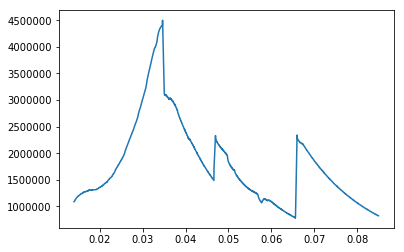

In [19]:
spectra_txt_file = fsel_spectra.selected
mycaltof = np.genfromtxt(spectra_txt_file, usecols=0)
myhist = np.genfromtxt(spectra_txt_file, usecols=1) #this is the cumulative histogram of the raw data (before the overlap correction)



plt.plot(mycaltof,myhist)
plt.show()

## Read the calibration datasets

### TOF sample directory

In [21]:
# here copy the path of the sample data
# alternative:
# pathdata = input("Copy the path for the sample data: ")
#ex: /media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Samples_AfterReboot_Corrected/

fsel_data= ipywe.fileselector.FileSelectorPanel(instruction='select path for the sample data', start_dir='.', type='directory')
fsel_data.show()

In [22]:
pathdata = fsel_data.selected
print(pathdata)

/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Samples_AfterReboot_Corrected


In [23]:
# Here copy the path of the open beam data
# alternative:
# pathOB = input('Copy the path for the open beam data: ')
# ex: /media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Flat_AfterReboot_Corrected/

fsel_ob= ipywe.fileselector.FileSelectorPanel(instruction='select path for the ob data', start_dir='.', type='directory')
fsel_ob.show()


In [24]:
pathOB = fsel_ob.selected

In [27]:
#sort the files
myfiles = fnmatch.filter(listdir(pathdata),'*.fits')
coll_files = sorted(myfiles)
obfiles = fnmatch.filter(listdir(pathOB),'*.fits') # here there are several OB folders
coll_ob = sorted(obfiles)


In [28]:
class bbox_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy(), cmap='gray', vmin=0, vmax=10)
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)


        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        color = (255,255,0)
        cv2.polylines(img,[pts],True,color,7)
                      
#         cv2.Rectangle(img, pt1, pt2, color, thickness=7)
#         pts = [[pt1],[pt2]]
        return img

    def onclick(self, event):
        display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)


select 4 points for a rectangular ROI, then click Disconnect mpl


<IPython.core.display.Javascript object>


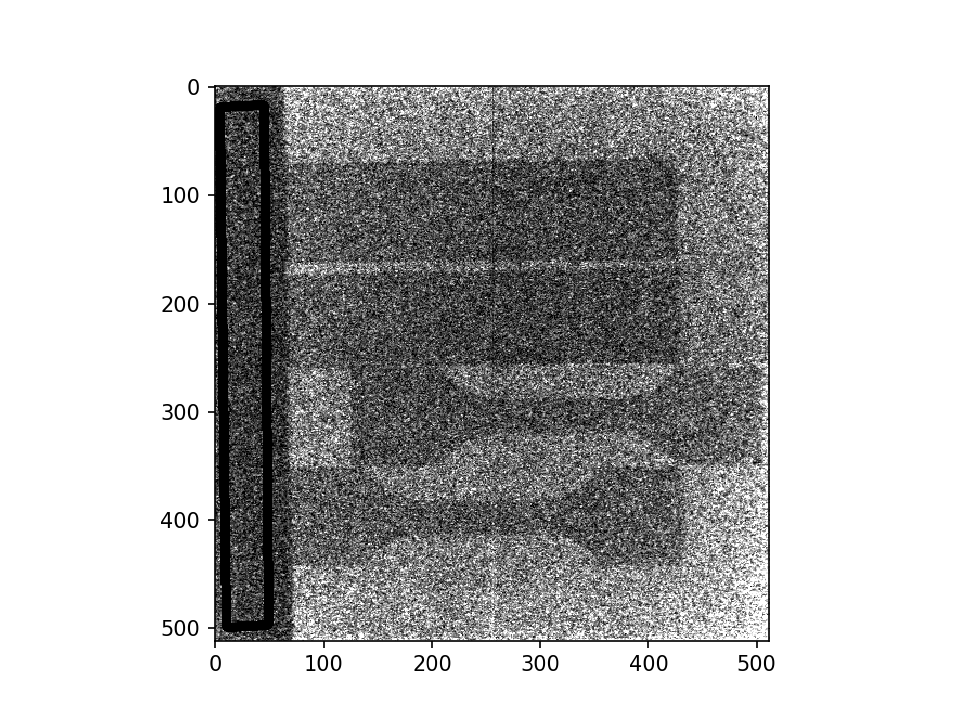

Button(description='Disconnect mpl', style=ButtonStyle())

In [30]:
print("select 4 points for a rectangular ROI, then click Disconnect mpl")
filename = pathdata +'/'+ coll_files[0]
im = fits.open(filename)
bs = bbox_select(im[0].data)
# here I have to change the fact that the ROI is blue like the image

In [31]:
bs.selected_points


[[4.994956540854901, 19.240268195346403],
 [10.536082081980453, 499.93290888798697],
 [49.323960869859235, 497.16234611742425],
 [45.16811671401507, 17.85498681006493]]

### Plot of the region used for calibration 

[[  4  19]
 [ 10 499]
 [ 49 497]
 [ 45  17]]


<IPython.core.display.Javascript object>


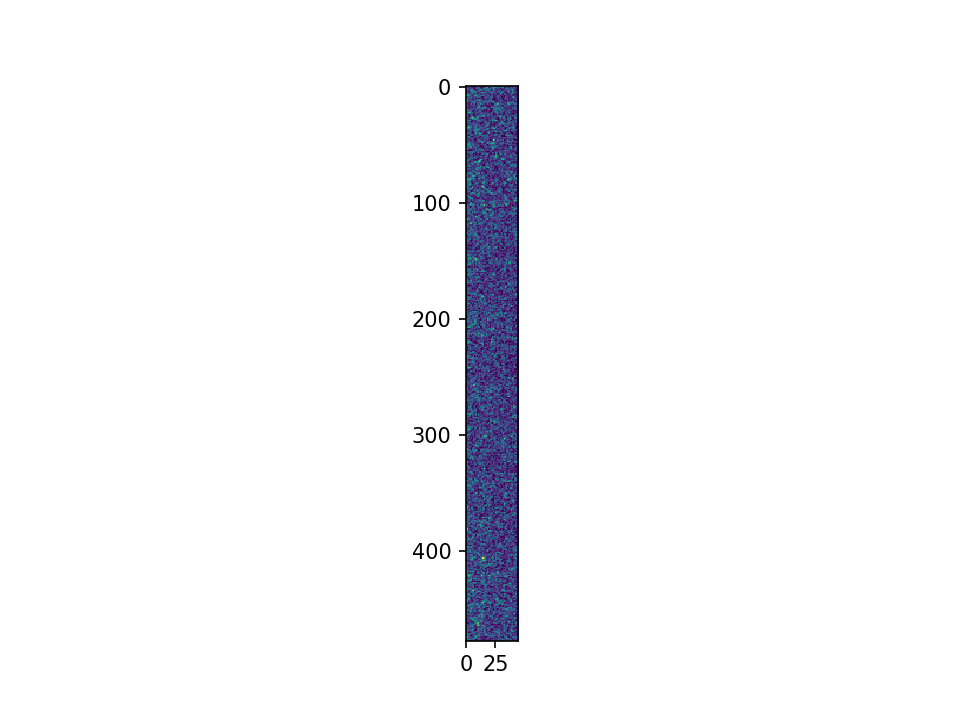

In [32]:
roi_cal = np.array([0,0, 10,10])
sel_points = np.squeeze(np.array([bs.selected_points],'int'))
print(sel_points)
roi_cal[0] = sel_points[0][0]
roi_cal[1] = sel_points[0][1]
roi_cal[2] = sel_points[2][0]
roi_cal[3] = sel_points [2][1]

plt.figure()
plt.imshow(im[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]) #this is the area that I want to study


### Load data and plot calibration spectrum

In [34]:
cal_spectrum = np.zeros(len(coll_files))
std_spectrum = np.zeros(len(coll_files))
cal_ob = np.zeros(len(coll_files))
std_ob = np.zeros(len(coll_files))
ori_hist = np.zeros(len(coll_files))
collImg= np.zeros([512,512,len(coll_files)])
collOB = np.zeros([512,512, len(coll_files)])

for i in range(0, len(coll_files)):
    
    curr_img = (fits.open(pathdata+'/'+coll_files[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    curr_ob =(fits.open(pathOB+'/'+coll_ob[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    cal_spectrum[i] = np.sum(curr_img[~np.isnan(curr_img) & ~np.isinf(curr_img)])
    cal_ob[i]= np.sum(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])
    std_spectrum[i] = np.std(curr_img/curr_ob)
#     std_ob[i] = np.std(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])
    
    
    

/home/carminati_c/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<IPython.core.display.Javascript object>


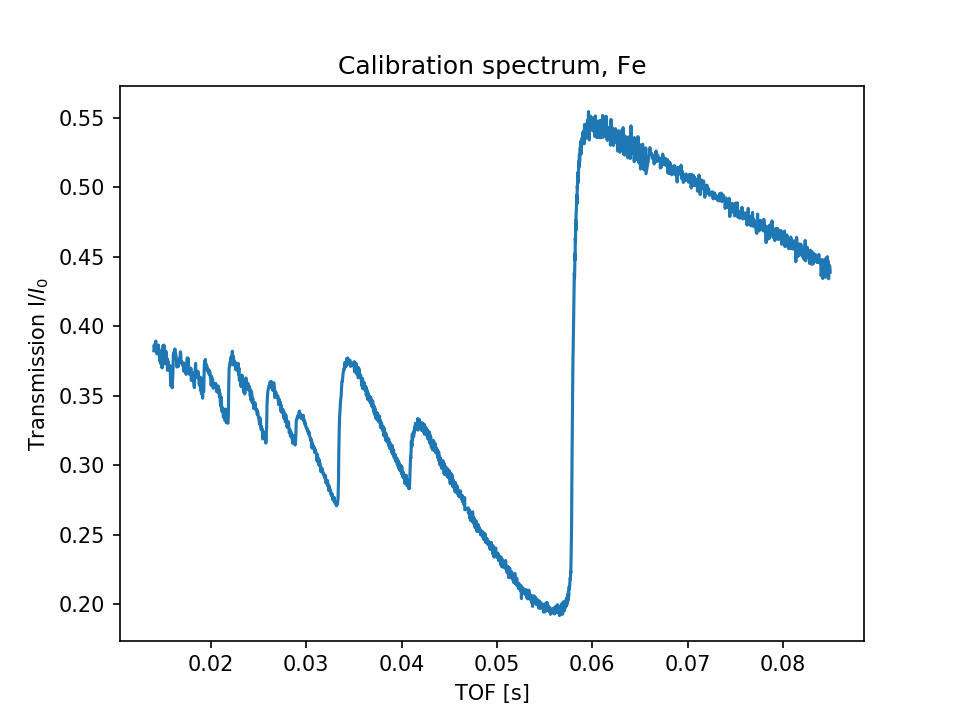

In [35]:
# Plot calibration spectrum 
cal_spectrum_norm = cal_spectrum/cal_ob
plt.figure()
plt.plot(mycaltof, (cal_spectrum/cal_ob))
plt.title('Calibration spectrum, Fe')
plt.xlabel('TOF [s]')
plt.ylabel('Transmission I/$I_{0}$')
plt.show()

<IPython.core.display.Javascript object>


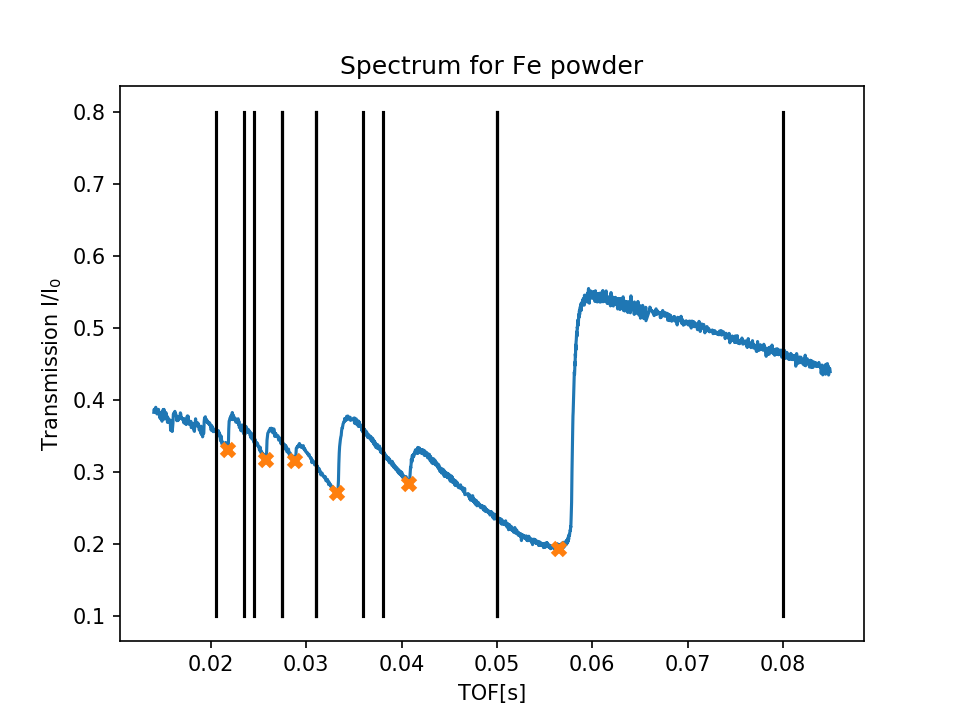

[0.0217824 0.0257555 0.0288275 0.0331693 0.0407971 0.056568 ]
[ 190  287  362  468  789 1543]


In [36]:
tof_ranges=np.zeros((6,2))

tof_ranges[5,0] = 0.05
tof_ranges[5,1] = 0.08

tof_ranges[4,0] =  0.038
tof_ranges[4,1] =  0.05

tof_ranges[3,0] = 0.031
tof_ranges[3,1] = 0.036

tof_ranges[2,0] = 0.0275
tof_ranges[2,1] =  0.031

tof_ranges[1,0] = 0.0245
tof_ranges[1,1] =  0.0275

tof_ranges[0,0] = 0.0205
tof_ranges[0,1] =  0.0235


peaks, _ = find_peaks(-cal_spectrum_norm, width=15)
plt.figure()
plt.plot(mycaltof, cal_spectrum_norm)
plt.plot(mycaltof[peaks],cal_spectrum_norm[peaks],'x', markeredgewidth=3)
for i in range(0,6):
    plt.plot((tof_ranges[i,0], tof_ranges[i,0]),(0.1,0.8), 'k-')
    plt.plot((tof_ranges[i,1], tof_ranges[i,1]),(0.1,0.8), 'k-')

plt.title('Spectrum for Fe powder')
plt.xlabel('TOF[s]')
plt.ylabel('Transmission I/I$_{0}$')
plt.show()
print(mycaltof[peaks])
print(peaks)


### here I loop over all selected peaks 

[ 190  287  362  468  789 1543]
--- RefPoints obtained from lattice parameters ---
[1.532 1.812 2.026 2.34  2.866 4.054]
number of peaks:  6
[0.0205 0.0235]
[159 232]
190
[0.0205 0.0235]
0.0217824
-----------Fitting calibration Bragg Edge--------------


<IPython.core.display.Javascript object>


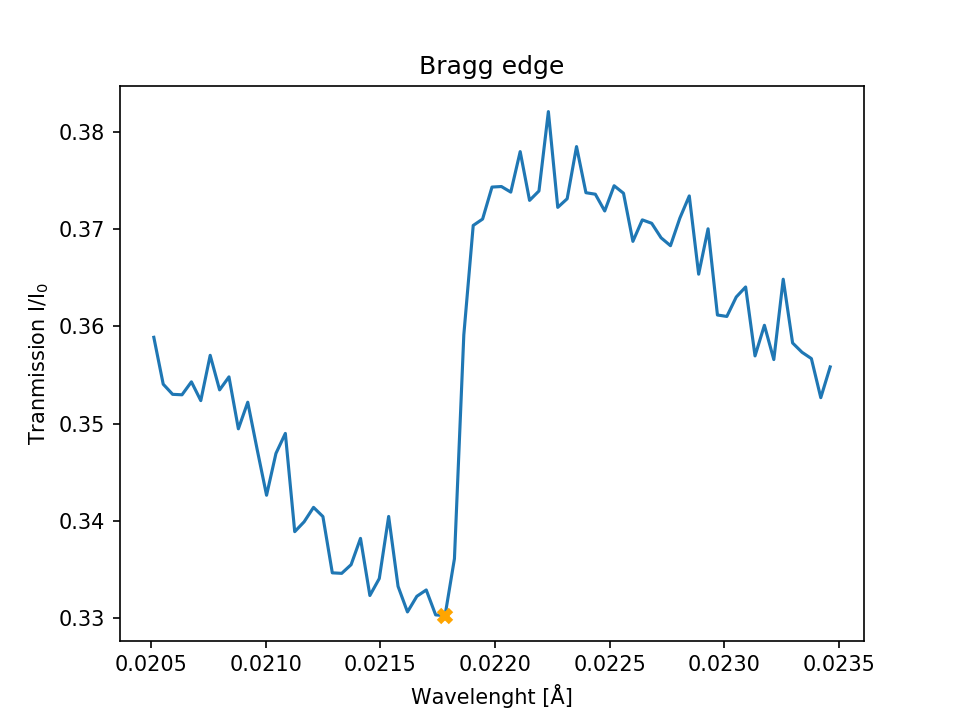

<IPython.core.display.Javascript object>


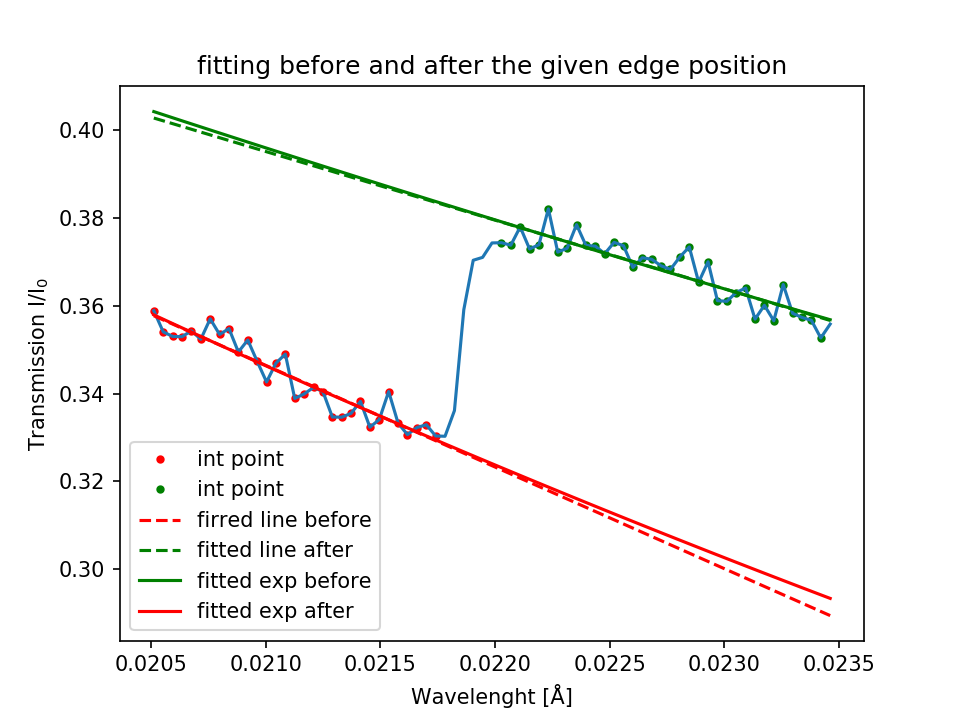

True


<IPython.core.display.Javascript object>


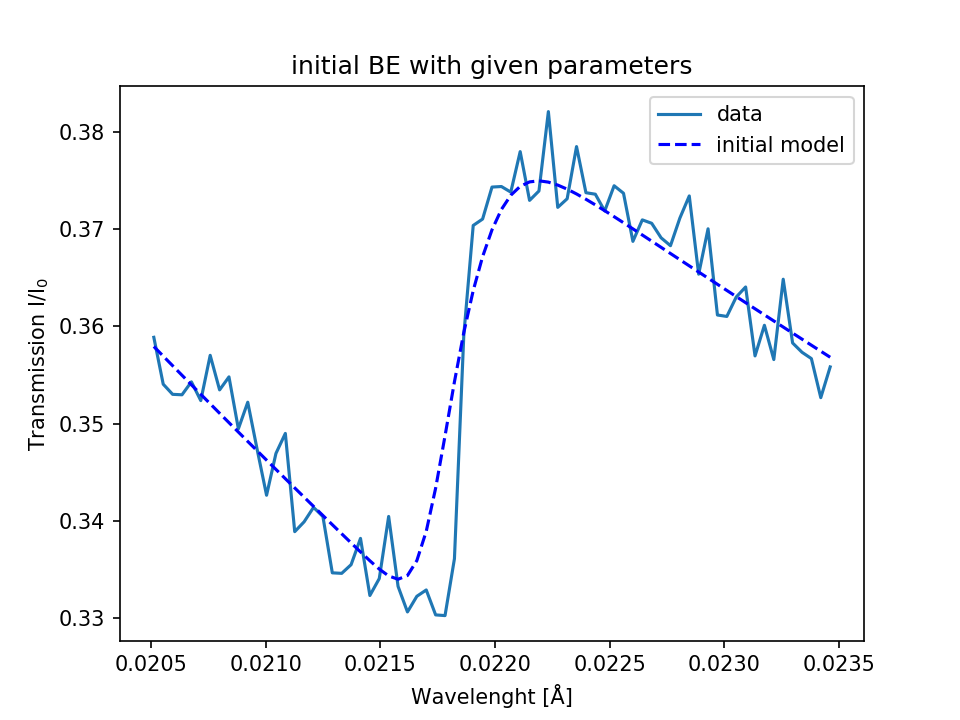

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 47
    # data points      = 73
    # variables        = 7
    chi-square         = 6.3440e-04
    reduced chi-square = 9.6121e-06
    Akaike info crit   = -836.690221
    Bayesian info crit = -820.657005
[[Variables]]
    t0:                 0.02180895 +/- 208.565654 (956330.70%) (init = 0.02184452)
    alpha:              7.3346e-05 +/- 1.0654e-05 (14.53%) (init = 3.724881e-05)
    sigma:              1.3490e-07 +/- 107471.700 (79666084904877.98%) (init = 3.875717e-05)
    a1:                -0.02009104 +/- 0.08370331 (416.62%) (init = 0.03681047)
    a2:                 44.8364423 +/- 3.67401552 (8.19%) (init = 42.3616)
    a5:                -0.32197175 +/- 0.12240092 (38.02%) (init = -0.4227518)
    a6:                 21.9399807 +/- 5.59989745 (25.52%) (init = 26.51332)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100

<IPython.core.display.Javascript object>


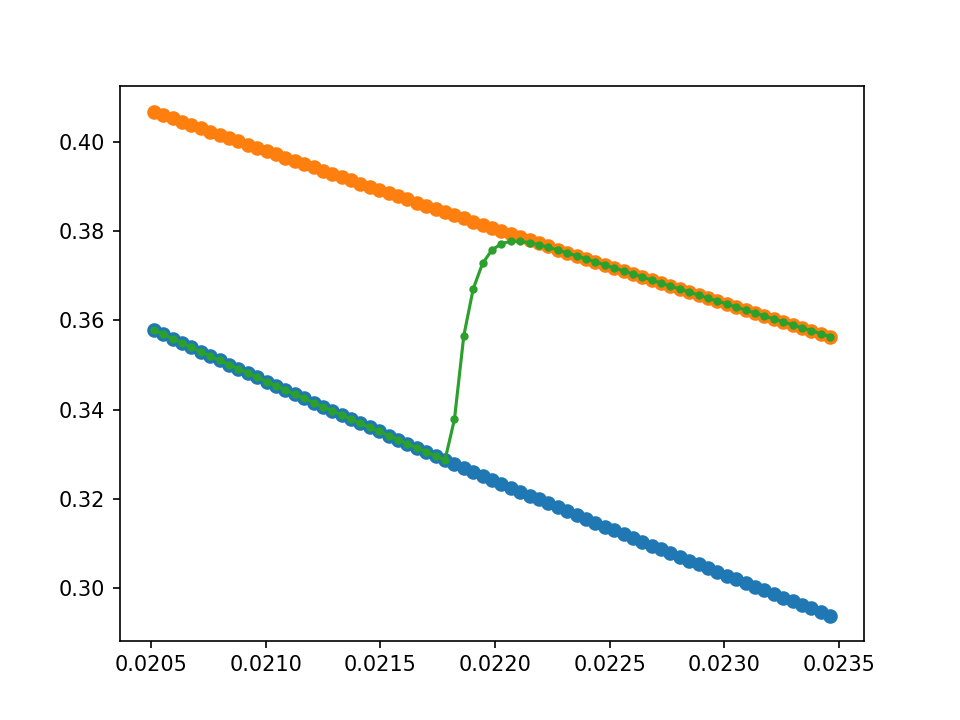

<IPython.core.display.Javascript object>


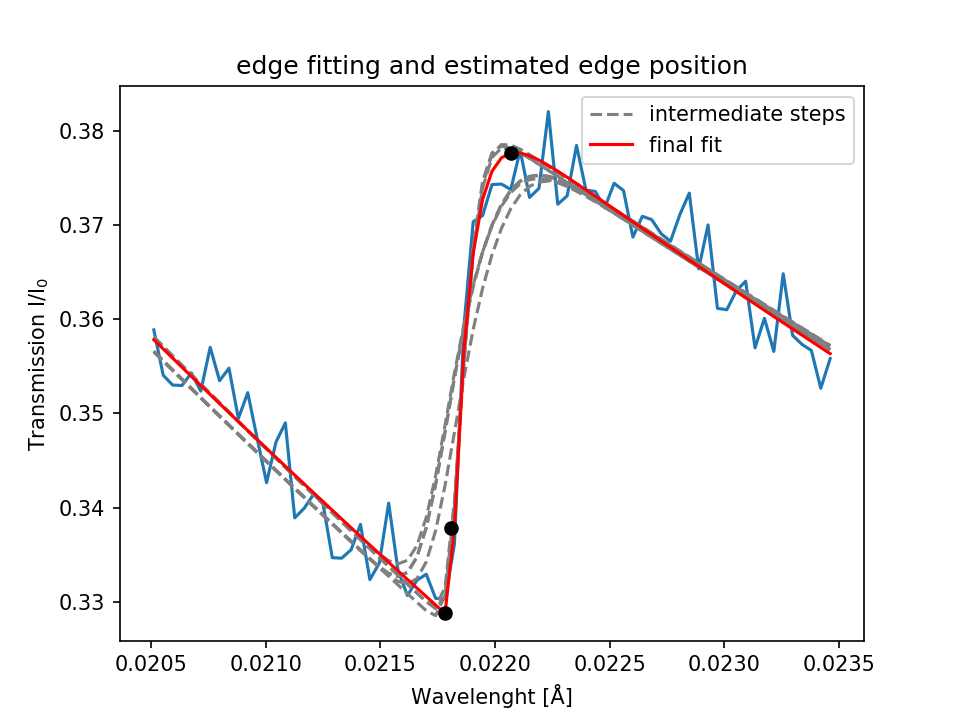

-----------Results of fitting: Edge Position------------
0.021808946748399338
[0.02180895 0.         0.         0.         0.         0.        ]
[0.0245 0.0275]
[256 330]
287
[0.0245 0.0275]
0.0257555
-----------Fitting calibration Bragg Edge--------------


<IPython.core.display.Javascript object>


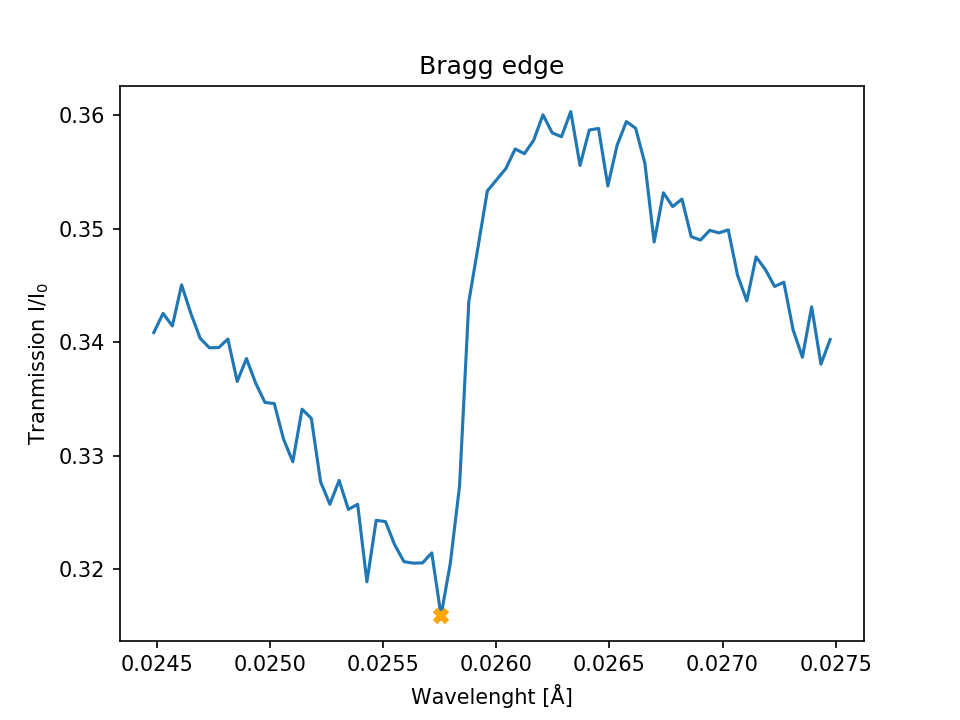

<IPython.core.display.Javascript object>


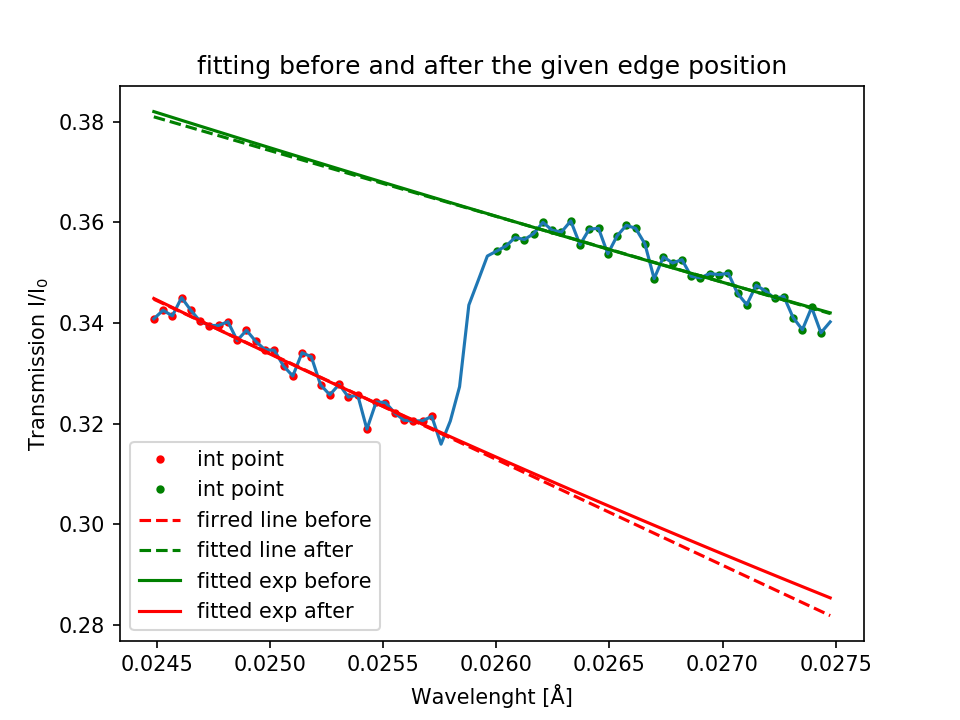

True


<IPython.core.display.Javascript object>


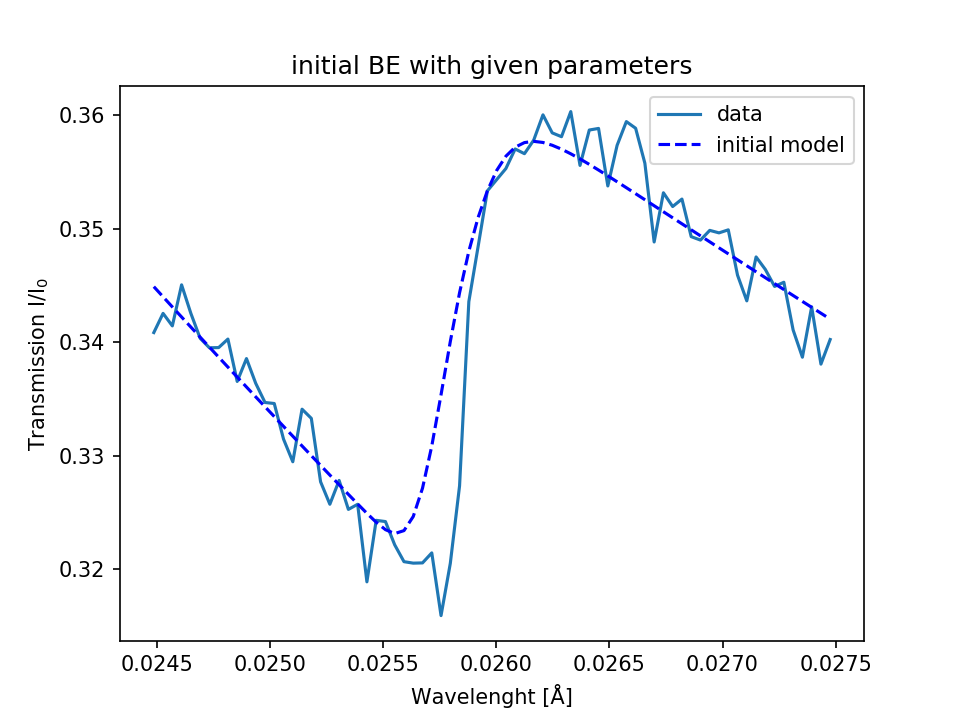

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 18
    # data points      = 74
    # variables        = 7
    chi-square         = 3.1491e-04
    reduced chi-square = 4.7002e-06
    Akaike info crit   = -901.178699
    Bayesian info crit = -885.050243
[[Variables]]
    t0:                 0.02579468 +/- 9.2496e-06 (0.04%) (init = 0.02580304)
    alpha:              1.3114e-04 +/- 1.6187e-05 (12.34%) (init = 0.0001006609)
    sigma:              1.3332e-05 +/- 1.2469e-05 (93.53%) (init = 1.697713e-05)
    a1:                -0.26809842 +/- 0.09430377 (35.18%) (init = -0.04293188)
    a2:                 49.0110982 +/- 3.50382217 (7.15%) (init = 40.68071)
    a5:                -0.24120534 +/- 0.12190962 (50.54%) (init = -0.5057176)
    a6:                 15.2501997 +/- 4.66304460 (30.58%) (init = 25.15938)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2) 

<IPython.core.display.Javascript object>


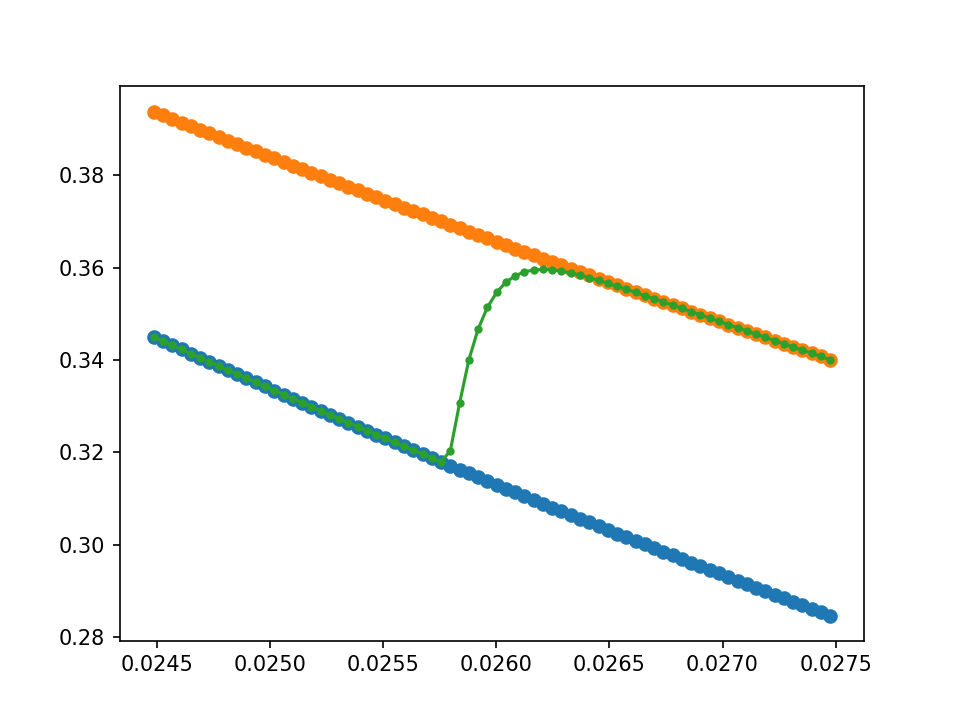

<IPython.core.display.Javascript object>


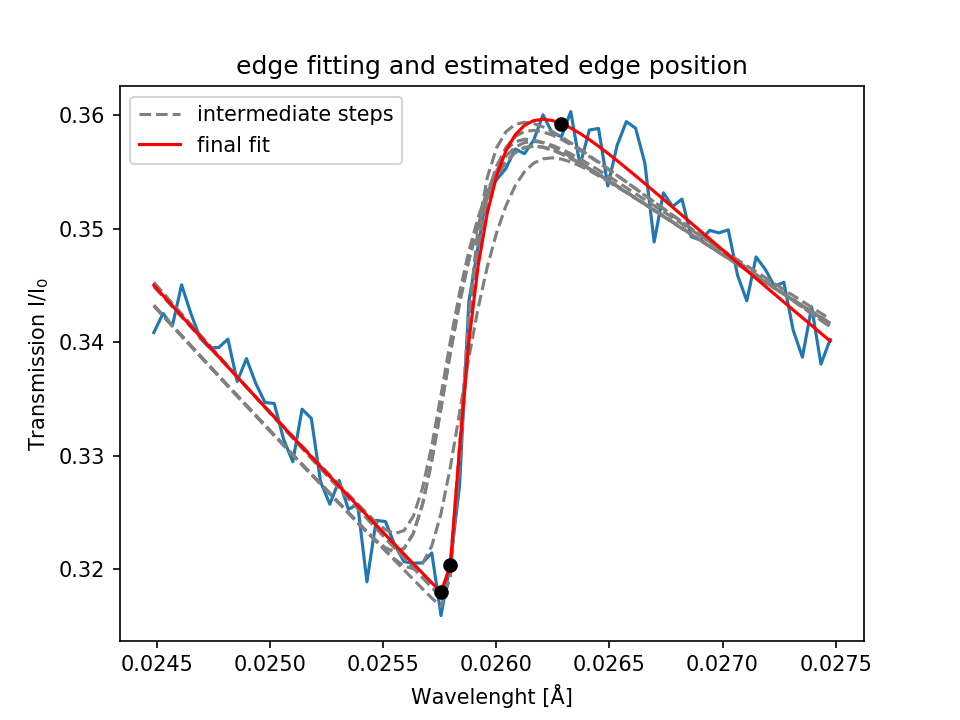

-----------Results of fitting: Edge Position------------
0.025794675336448795
[0.02180895 0.02579468 0.         0.         0.         0.        ]
[0.0275 0.031 ]
[330 415]
362
[0.0275 0.031 ]
0.0288275
-----------Fitting calibration Bragg Edge--------------


<IPython.core.display.Javascript object>


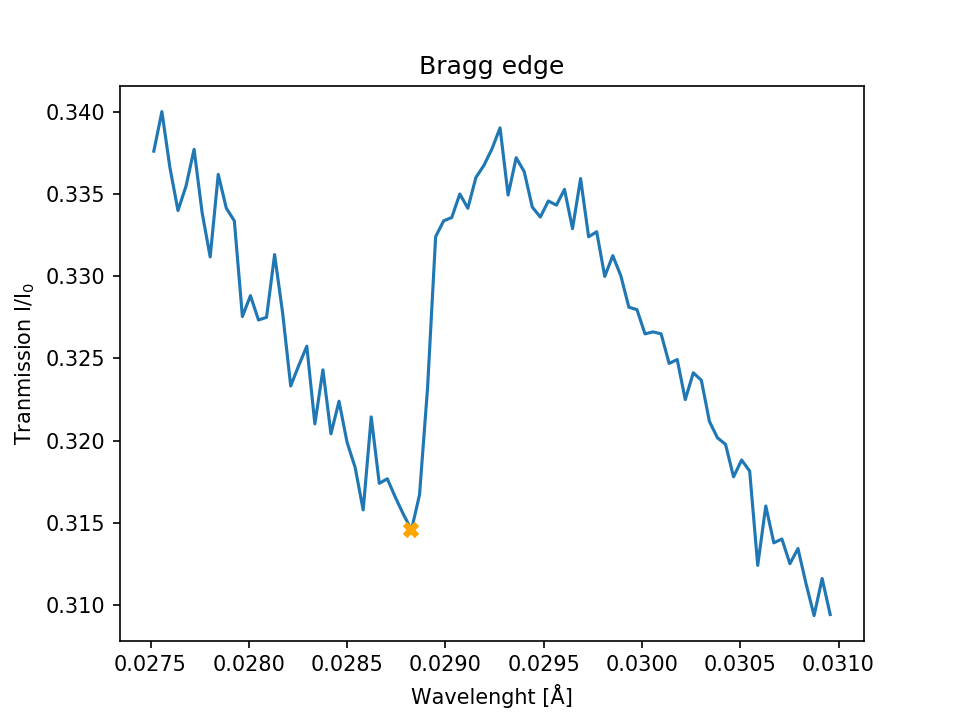

<IPython.core.display.Javascript object>


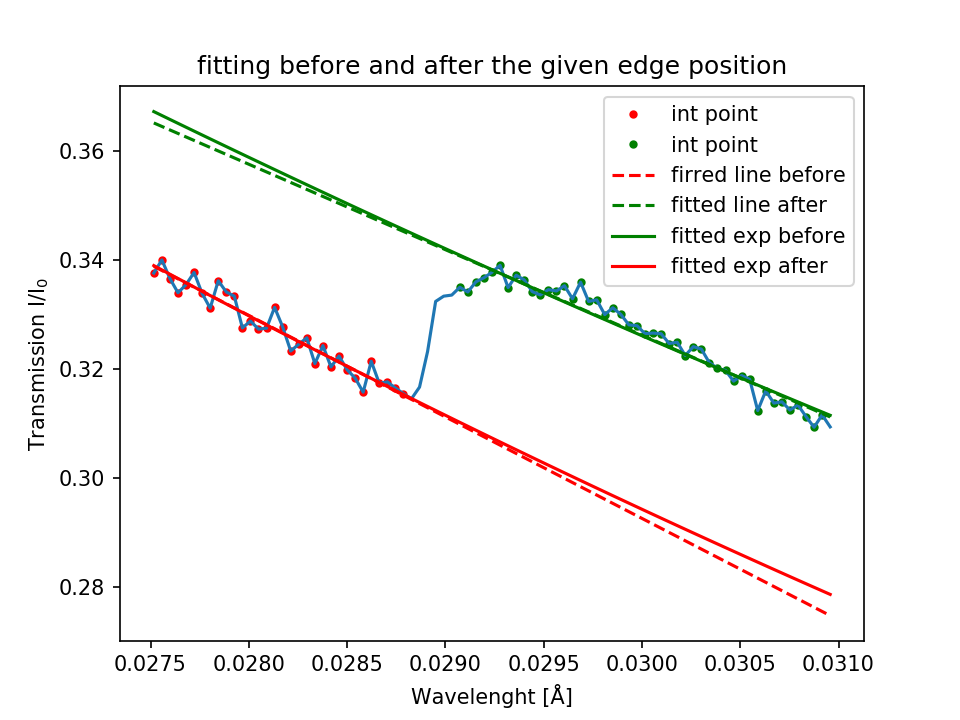

True


<IPython.core.display.Javascript object>


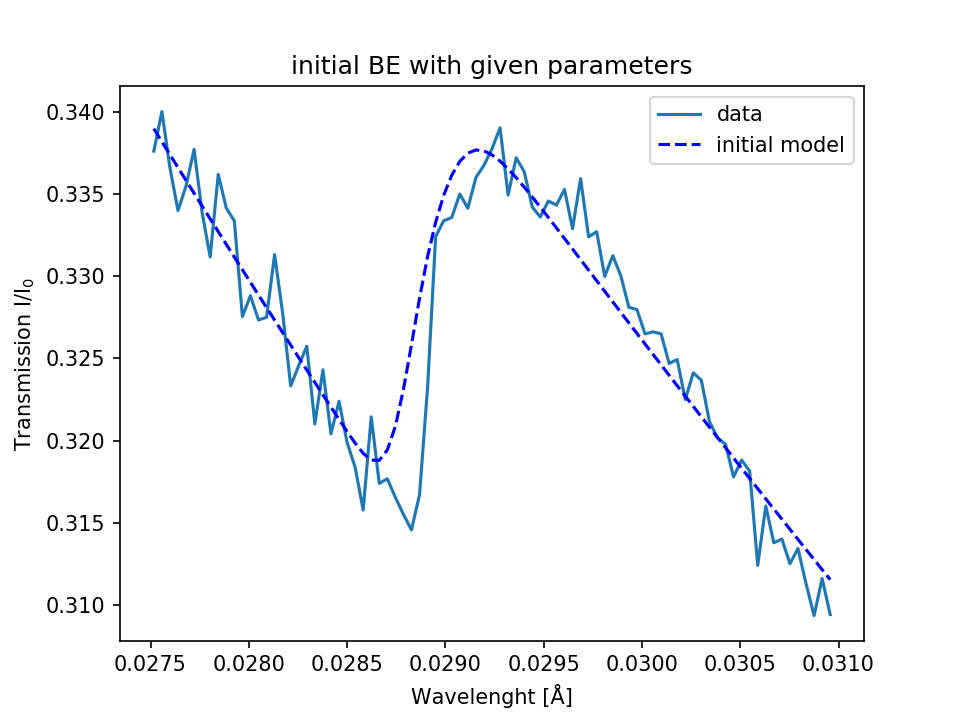

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 59
    # data points      = 85
    # variables        = 7
    chi-square         = 2.3139e-04
    reduced chi-square = 2.9665e-06
    Akaike info crit   = -1075.19652
    Bayesian info crit = -1058.09797
[[Variables]]
    t0:                 0.02883861 +/- 237.386546 (823155.33%) (init = 0.02884934)
    alpha:              1.9054e-04 +/- 2.2155e-05 (11.63%) (init = 0.000132877)
    sigma:              1.3980e-06 +/- 32183.8056 (2302157040587.46%) (init = 3.157869e-06)
    a1:                -0.60702250 +/- 0.06921004 (11.40%) (init = -0.3908562)
    a2:                 57.4670897 +/- 2.28598355 (3.98%) (init = 50.35757)
    a5:                 0.12314275 +/- 0.09583240 (77.82%) (init = -0.1636179)
    a6:                -0.56720965 +/- 3.28139942 (578.52%) (init = 9.06919)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100)


<IPython.core.display.Javascript object>


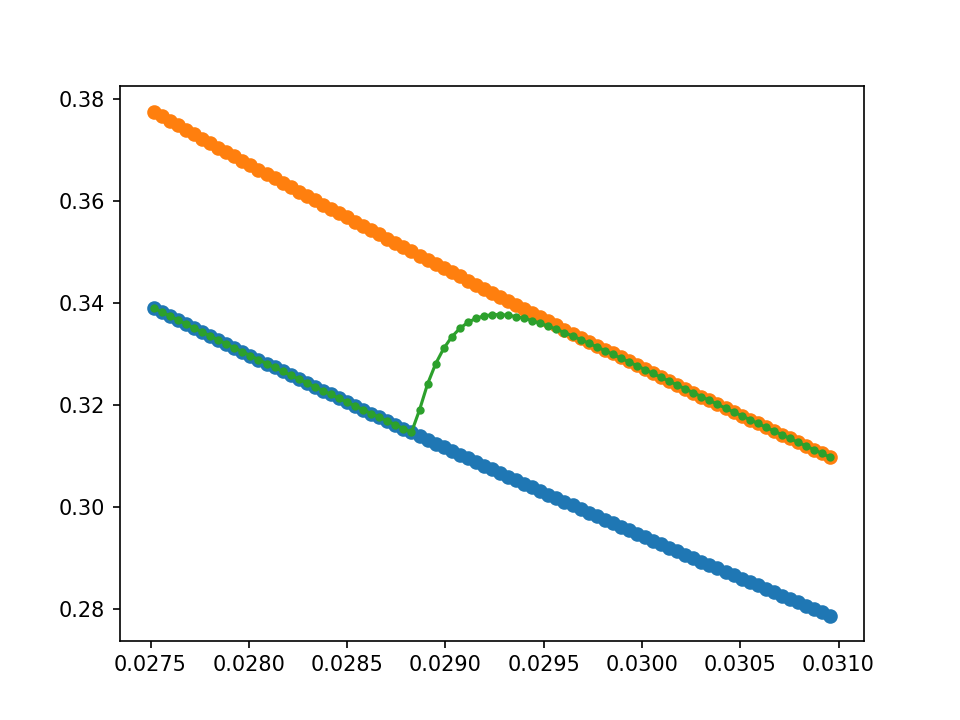

<IPython.core.display.Javascript object>


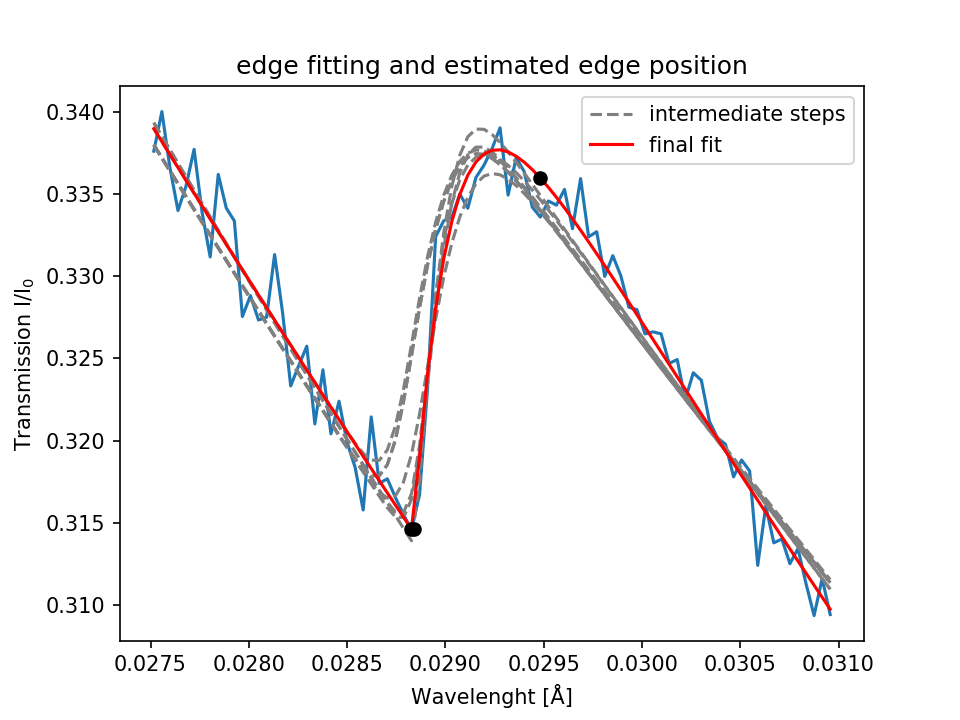

-----------Results of fitting: Edge Position------------
0.02883860901899633
[0.02180895 0.02579468 0.02883861 0.         0.         0.        ]
[0.031 0.036]
[415 555]
468
[0.031 0.036]
0.0331693
-----------Fitting calibration Bragg Edge--------------


<IPython.core.display.Javascript object>


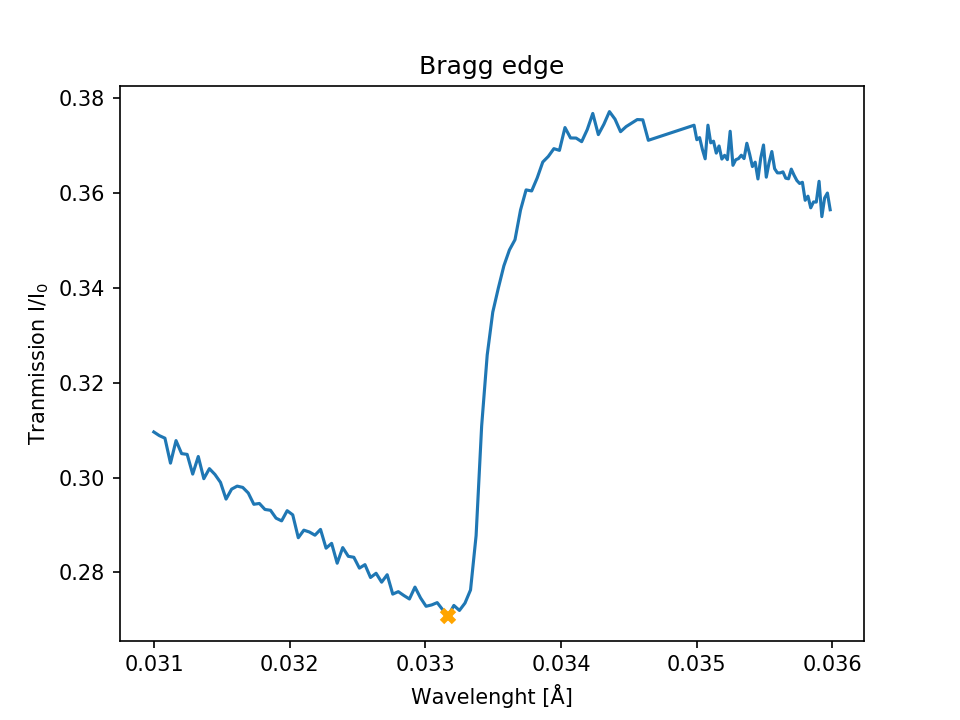

<IPython.core.display.Javascript object>


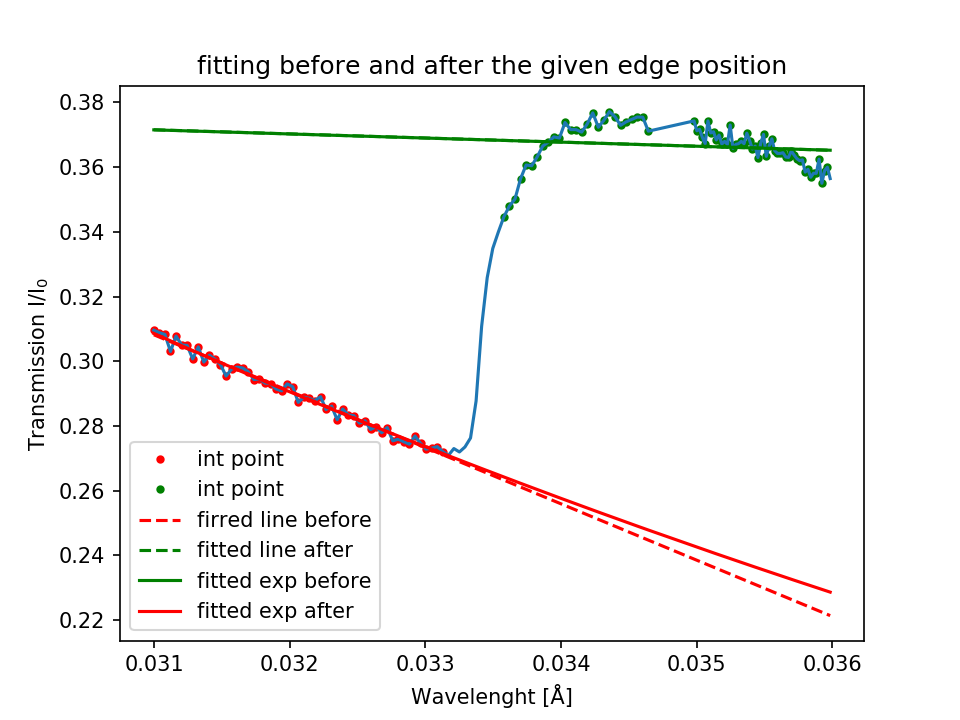

True


<IPython.core.display.Javascript object>


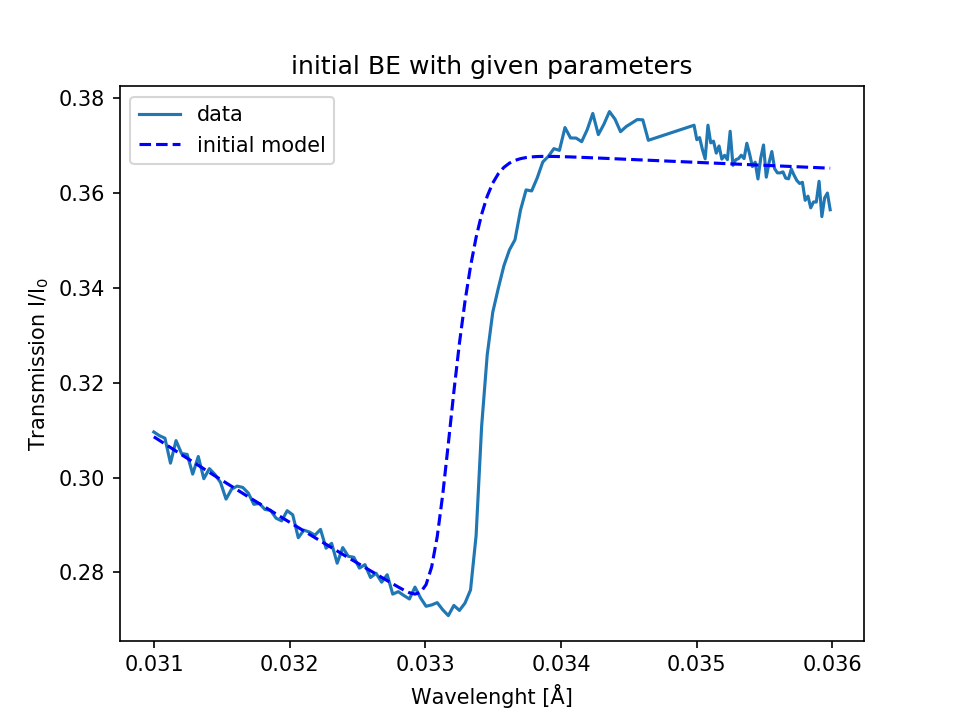

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 140
    # variables        = 7
    chi-square         = 7.1124e-04
    reduced chi-square = 5.3477e-06
    Akaike info crit   = -1692.62017
    Bayesian info crit = -1672.02867
[[Variables]]
    t0:                 0.03330435 +/- 5.6490e-06 (0.02%) (init = 0.03341062)
    alpha:              2.6573e-04 +/- 1.1734e-05 (4.42%) (init = 0.0001039754)
    sigma:              1.8729e-05 +/- 1.0527e-05 (56.21%) (init = 0.0001018948)
    a1:                -0.01500620 +/- 0.06805334 (453.50%) (init = 0.7107745)
    a2:                 28.8079685 +/- 1.92448646 (6.68%) (init = 8.332842)
    a5:                -0.64383965 +/- 0.08603039 (13.36%) (init = -1.513824)
    a6:                 30.3961495 +/- 2.52781817 (8.32%) (init = 55.41521)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)    

<IPython.core.display.Javascript object>


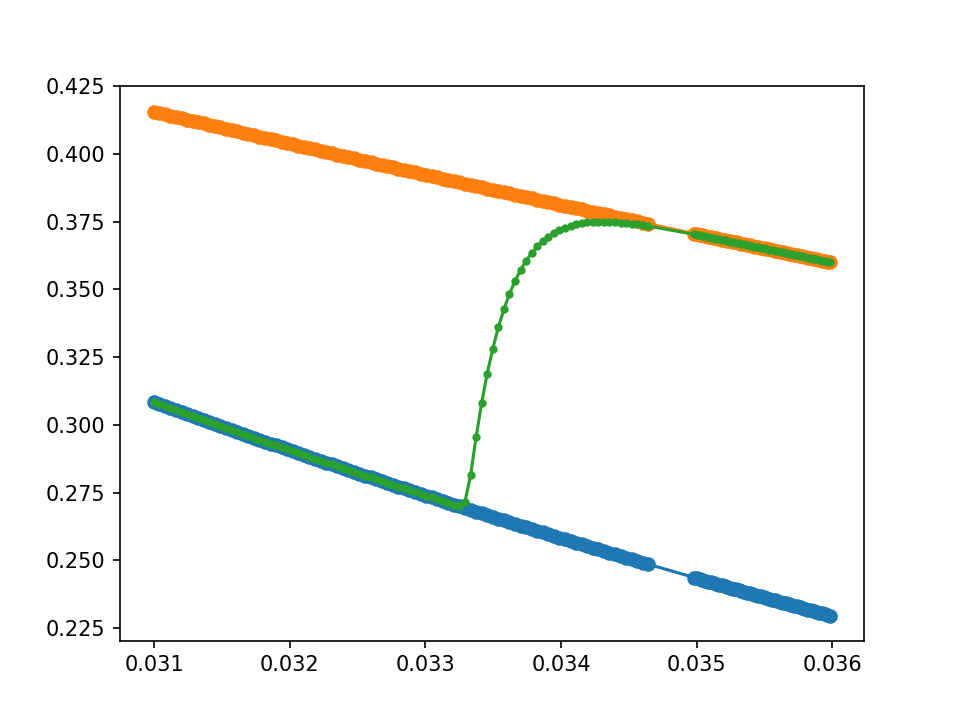

/home/carminati_c/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


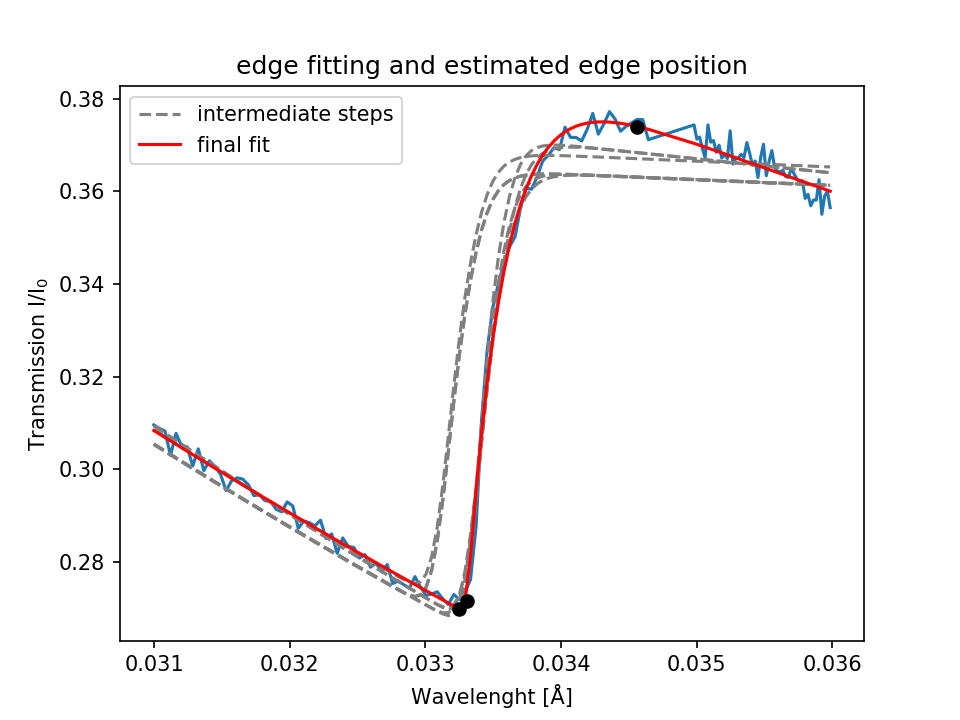

-----------Results of fitting: Edge Position------------
0.03330435485211112
[0.02180895 0.02579468 0.02883861 0.03330435 0.         0.        ]
[0.038 0.05 ]
[ 652 1222]
789
[0.038 0.05 ]
0.0407971
-----------Fitting calibration Bragg Edge--------------


<IPython.core.display.Javascript object>


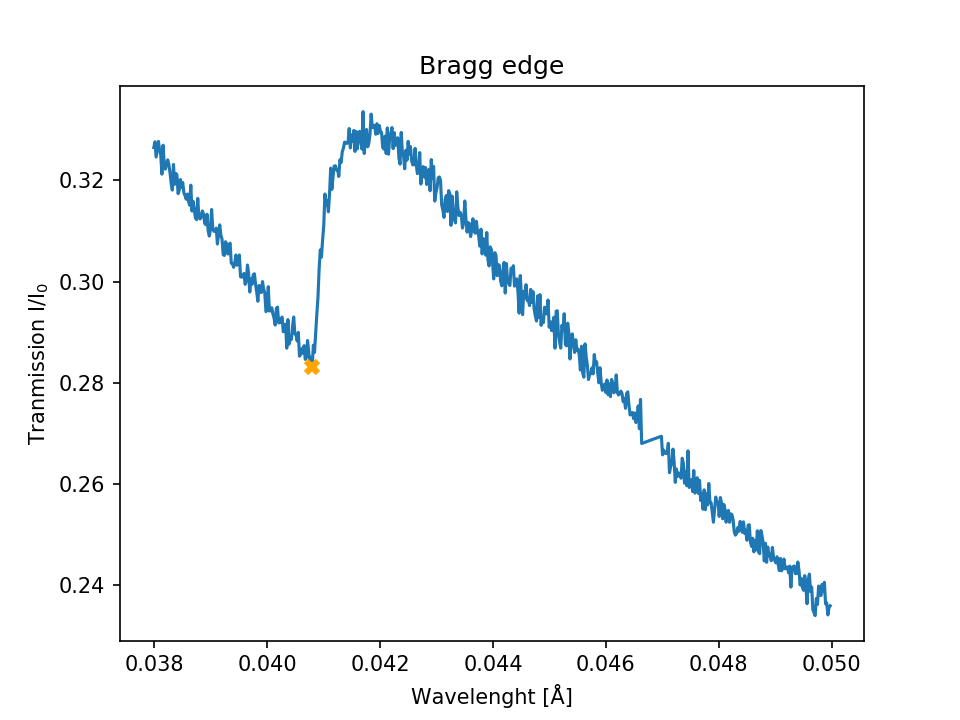

<IPython.core.display.Javascript object>


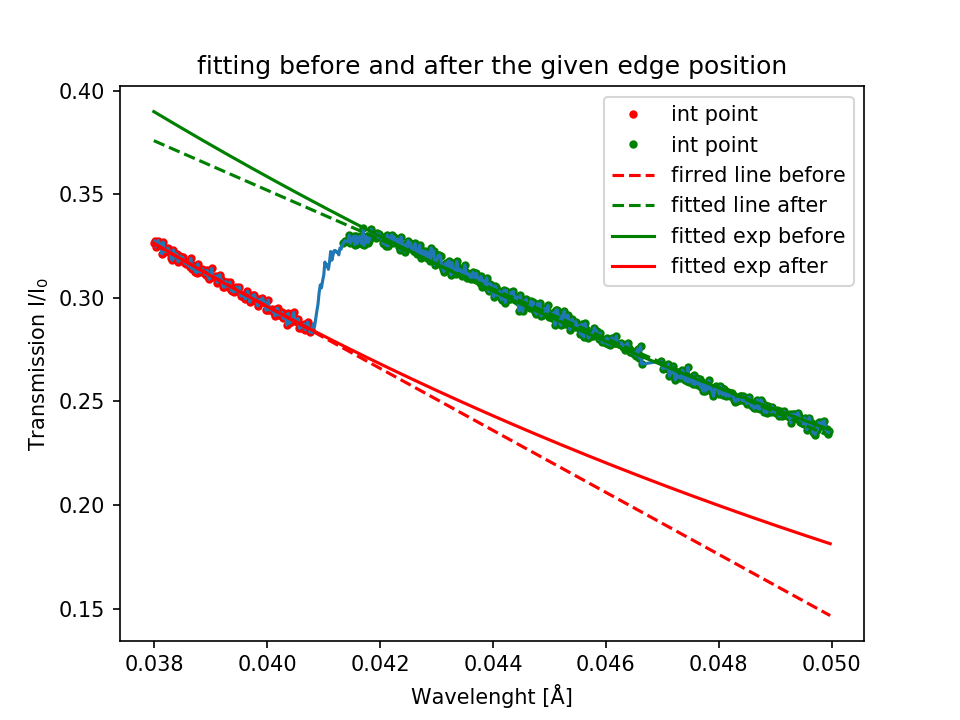

True


<IPython.core.display.Javascript object>


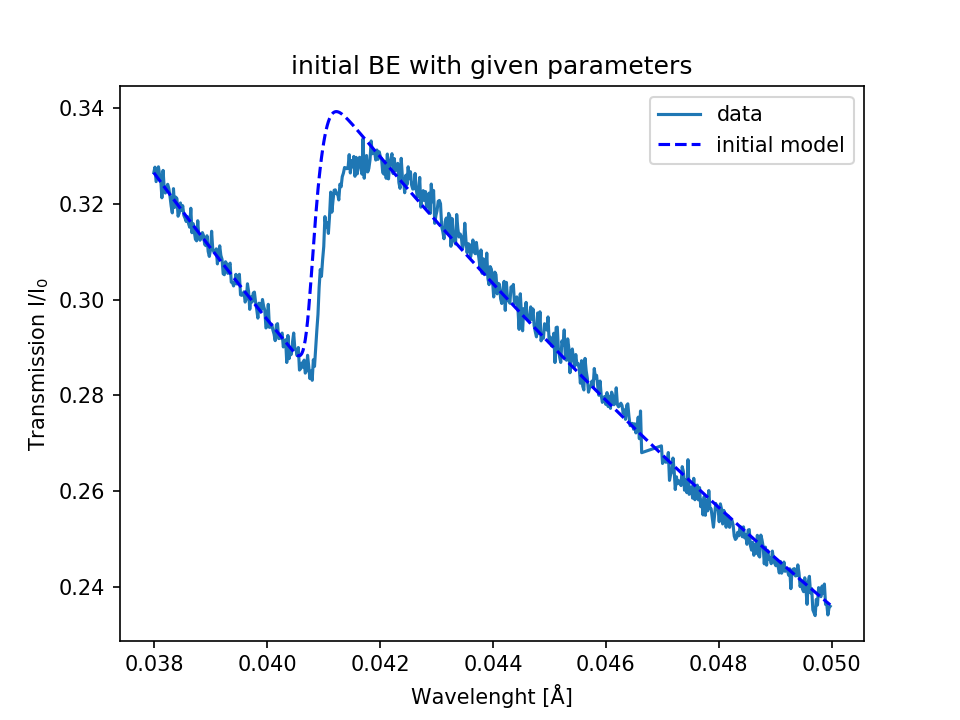

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 570
    # variables        = 7
    chi-square         = 0.00224481
    reduced chi-square = 3.9872e-06
    Akaike info crit   = -7079.51930
    Bayesian info crit = -7049.09984
[[Variables]]
    t0:                 0.04079445 +/- 3.18443278 (7806.04%) (init = 0.0407986)
    alpha:              3.9523e-04 +/- 9.7232e-06 (2.46%) (init = 0.0003530079)
    sigma:              1.1078e-08 +/- 67927.4457 (613171480098480.12%) (init = 1.629101e-08)
    a1:                -0.73122569 +/- 0.00779728 (1.07%) (init = -0.6815085)
    a2:                 43.6133629 +/- 0.17038905 (0.39%) (init = 42.55321)
    a5:                -0.01397790 +/- 0.02827670 (202.30%) (init = -0.121007)
    a6:                 5.46724473 +/- 0.71180428 (13.02%) (init = 7.998061)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100)
 

<IPython.core.display.Javascript object>


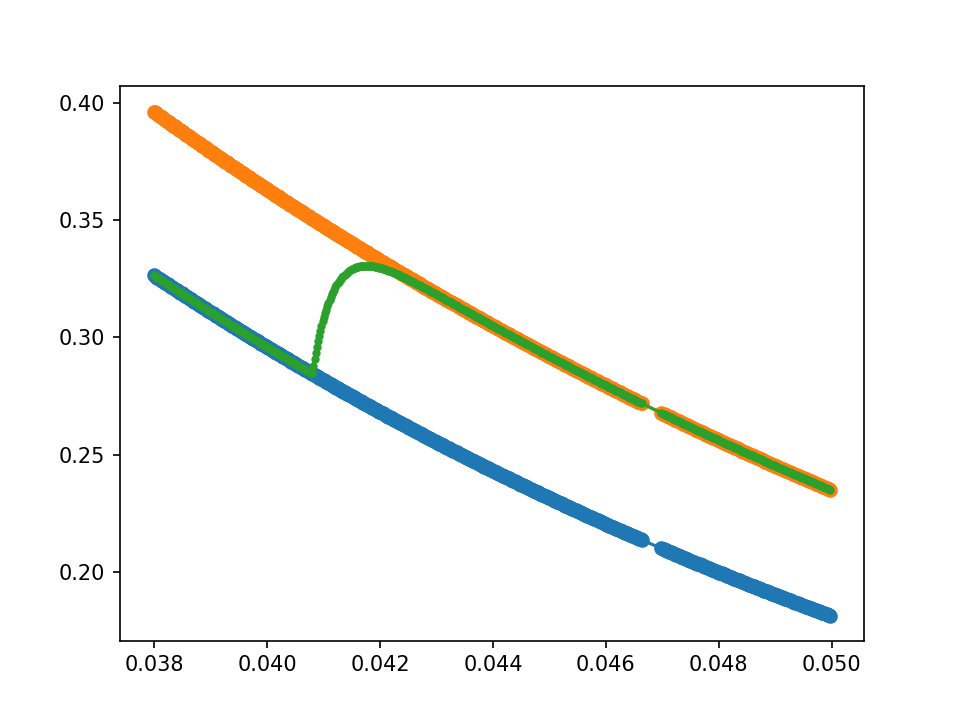

<IPython.core.display.Javascript object>


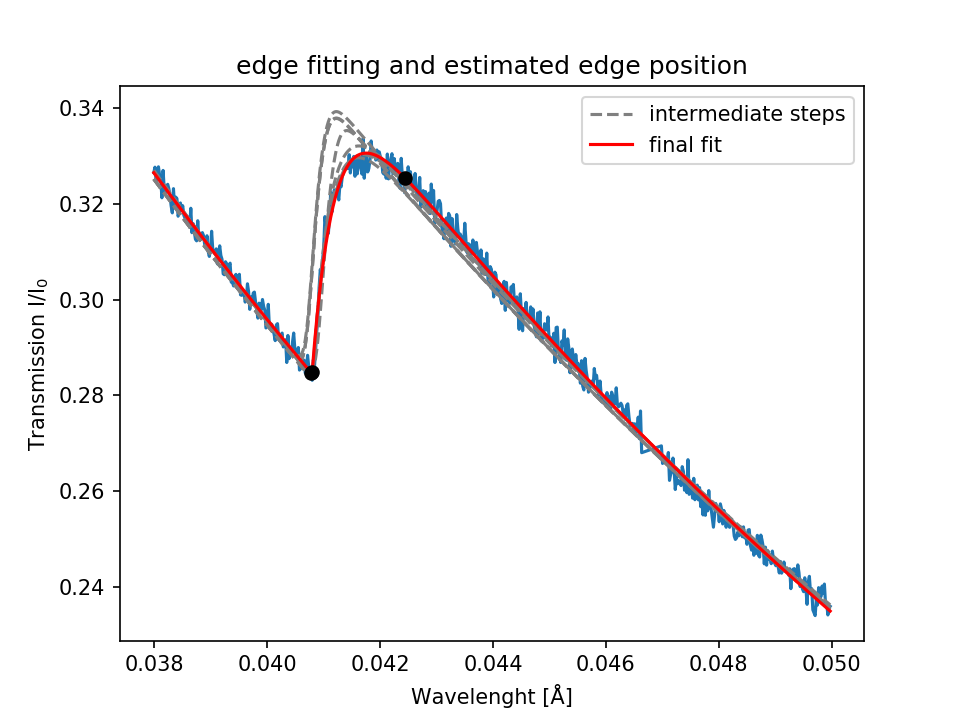

-----------Results of fitting: Edge Position------------
0.04079444766990863
[0.02180895 0.02579468 0.02883861 0.03330435 0.04079445 0.        ]
[0.05 0.08]
[1222 2329]
1543
[0.05 0.08]
0.056568
-----------Fitting calibration Bragg Edge--------------


<IPython.core.display.Javascript object>


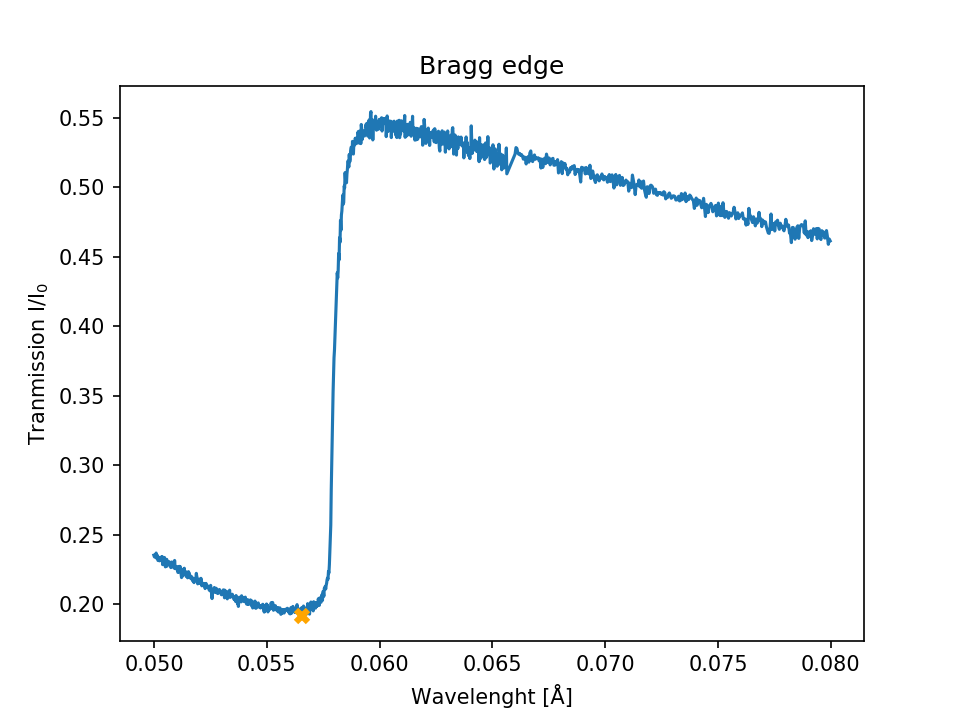

<IPython.core.display.Javascript object>


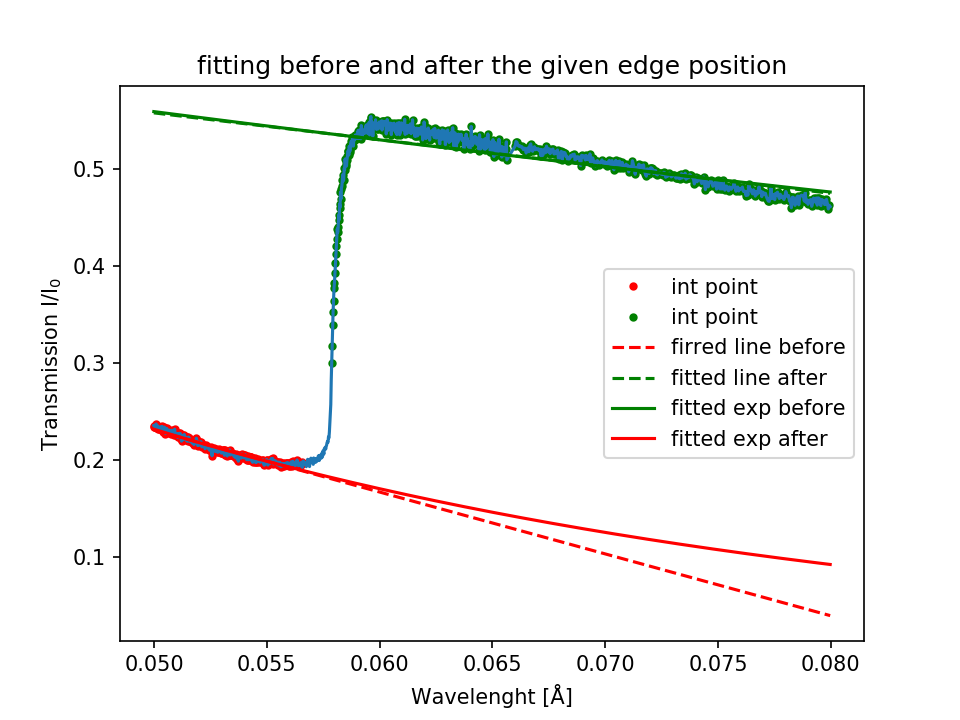

True


<IPython.core.display.Javascript object>


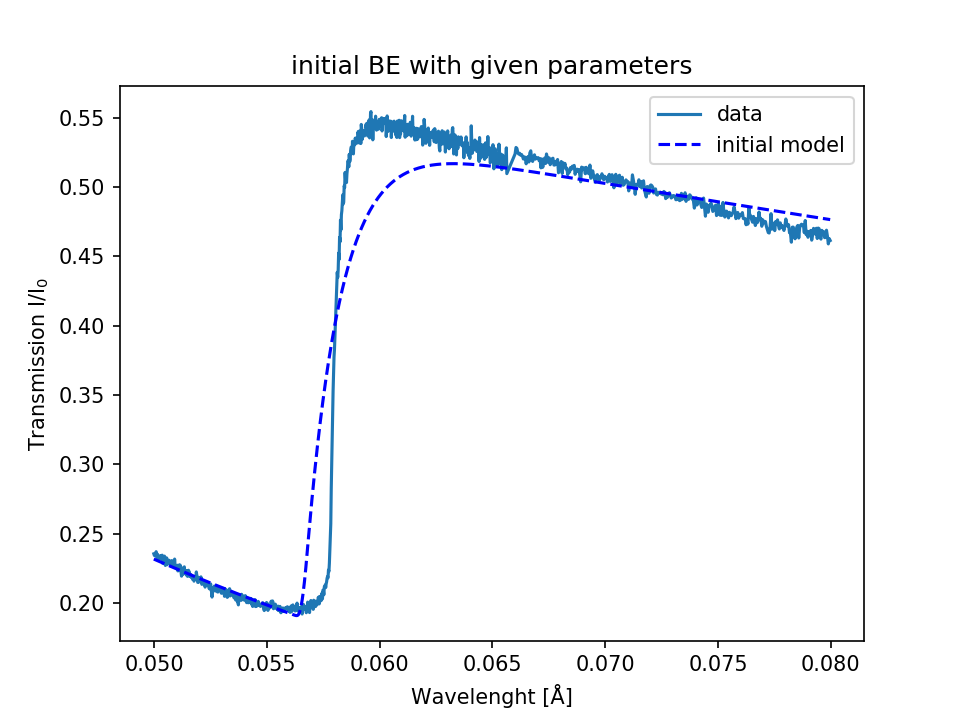

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.03562059
    reduced chi-square = 3.2382e-05
    Akaike info crit   = -11437.0739
    Bayesian info crit = -11402.0081
[[Variables]]
    t0:                 0.05792264 +/- 2.2275e-05 (0.04%) (init = 0.05792738)
    alpha:              2.0515e-04 +/- 1.2932e-05 (6.30%) (init = 0.0001997701)
    sigma:              2.1539e-04 +/- 1.5015e-05 (6.97%) (init = 0.0002233033)
    a1:                 0.14255188 +/- 0.00471034 (3.30%) (init = 0.1529915)
    a2:                 7.74702219 +/- 0.06988114 (0.90%) (init = 7.600425)
    a5:                 0.03338035 +/- 0.03613866 (108.26%) (init = -0.1166503)
    a6:                 18.2047259 +/- 0.67340956 (3.70%) (init = 21.01407)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    

<IPython.core.display.Javascript object>


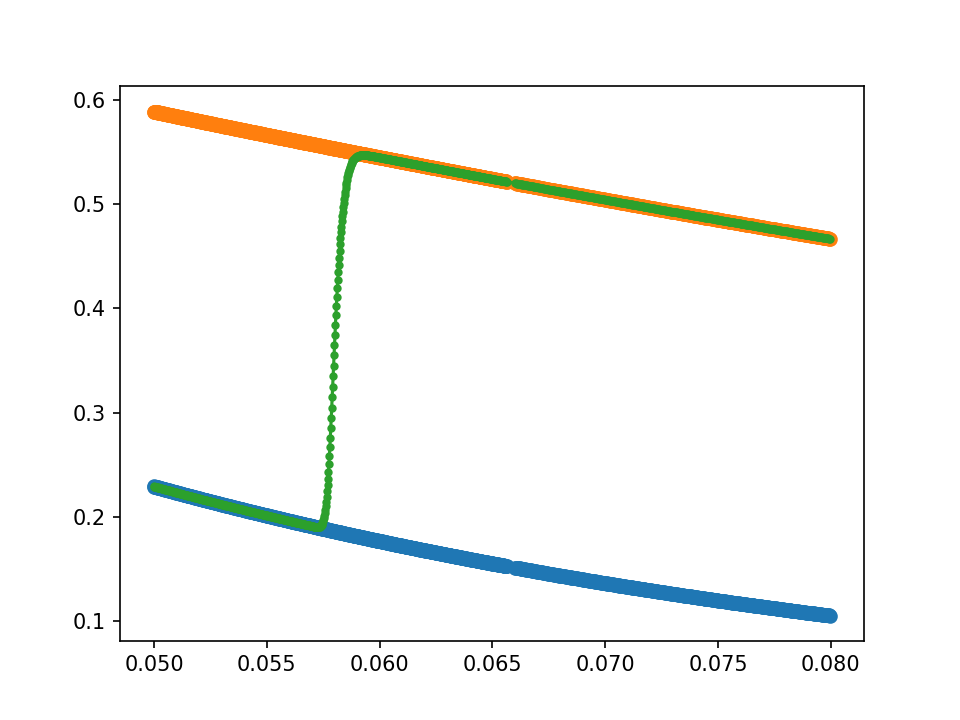

<IPython.core.display.Javascript object>


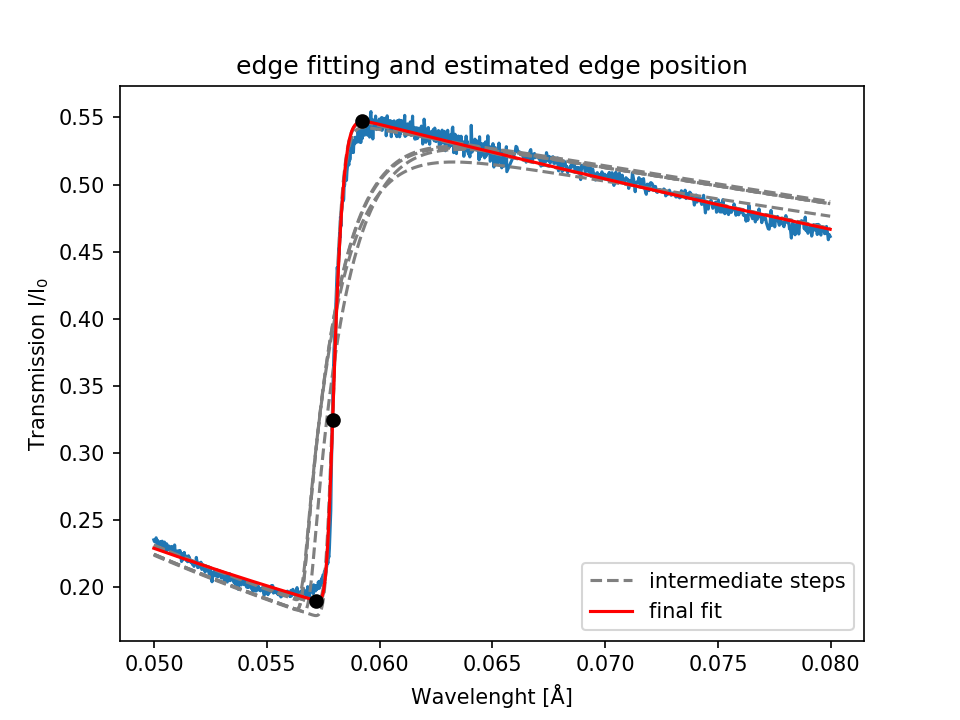

-----------Results of fitting: Edge Position------------
0.05792264401728054
[0.02180895 0.02579468 0.02883861 0.03330435 0.04079445 0.05792264]
computed moderator decay:
[1.34902701e-07 1.33319918e-05 1.39798480e-06 1.87294253e-05
 1.10780504e-08 2.15386710e-04]
[1.532 1.812 2.026 2.34  2.866 4.054]
[0.02180895 0.02579468 0.02883861 0.03330435 0.04079445 0.05792264]
5


In [37]:

print(peaks) # here I see which are the positions of the peaks in the cal spectrum


#in TOF [s!]
est_sigma = 0.0001
est_alpha = np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0015]) # This takes into account that the alpha values as a pseudo-sigmoid behaviour
CalPoints = np.zeros(6)
RefPoints = np.zeros(6)

RefPoints[0]=dhkl_alphaFe[6]*2

#Here I exclude the peak for hkl (2,2,2)
for i in range(1, 6):
    RefPoints[i]=dhkl_alphaFe[5-i]*2

print('--- RefPoints obtained from lattice parameters ---')
print(RefPoints)
print('number of peaks: ',len(peaks))

computed_alpha = np.zeros(len(peaks))

for i in range(0, len(peaks)):
# for i in range(len(peaks)-1, len(peaks)):
    
    print(tof_ranges[i,:])
    myrange = np.array([find_nearest(mycaltof, tof_ranges[i,0]), find_nearest(mycaltof,tof_ranges[i,1])])
    print(myrange)
    print(peaks[i])
    print(tof_ranges[i,:])
    print(mycaltof[peaks[i]])
            

    print('-----------Fitting calibration Bragg Edge--------------')
    results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, mycaltof, peaks[i], est_sigma, est_alpha[i], False, False, False,True)
    print('-----------Results of fitting: Edge Position------------')
    print(results_cal['t0'])

#     CalPoints[i] = mycaltof[myrange[0]+int(results_cal['t0'])]
    CalPoints[i] = results_cal['t0']
    computed_alpha[i] = results_cal['sigma']

    print(CalPoints)
#     print(RefPoints)

print('computed moderator decay:')
print(computed_alpha)
print(RefPoints)
print(CalPoints)
print(i)

## I will then fit the calculated TOF to the theoretical lambda, x= RefPoints (theoretical lambda) y=mycaltof (computed TOF) 

[1.532 1.812 2.026 2.34  2.866 4.054]
[0.02180895 0.02579468 0.02883861 0.03330435 0.04079445 0.05792264]
Calibration parameters:
flight path L: 56.640031920069646 m
T0: 0.0001665922790161006 s
[6.98451939e+01 1.16356700e-02]


<IPython.core.display.Javascript object>


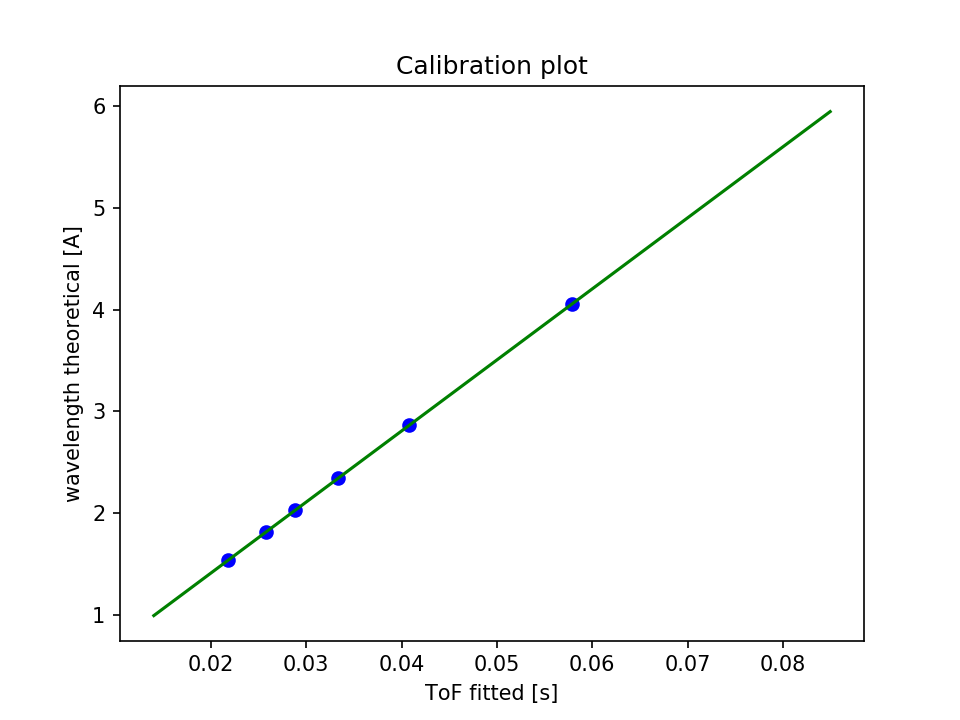

Text(0.5, 1.0, 'Calibration plot')

In [38]:
#Calibration on the lattice parameters value
print(RefPoints) # theoretical lambda
print(CalPoints) # calculated TOF
h=6.62607004e-34 #Planck constant [m^2 kg / s]
m=1.674927471e-27 #Neutron mass [kg]

z= np.polyfit( CalPoints,RefPoints,1)
print('Calibration parameters:')
print('flight path L:', (h/(m*z[0]))/1e-10, 'm')
print('T0:', z[1]/z[0] ,'s')
print(z)

plt.figure()
plt.plot(CalPoints,RefPoints,'ob')
plt.plot( mycaltof, mycaltof*z[0]+z[1],'-g')
plt.ylabel('wavelength theoretical [A]')
plt.xlabel('ToF fitted [s]')
plt.title('Calibration plot')
